# Customer Churn Prediction with Classical Machine Learning Models

## Import Libraries  

In [102]:
# Data packages
import numpy as np
import pandas as pd

# Machine Learning / Classification packages
import scipy.stats as ss
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
)
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# Visualization Packages
from matplotlib import pyplot as plt
import seaborn as sns

## Functions 

### Utility Functions

In [103]:
def print_dataframe_stats(df: pd.DataFrame) -> None:
    """Print various statistics about a DataFrame.
    
    Args:
        df (pd.DataFrame): The DataFrame to print statistics for.
    """
    
    print(f"Rows   : {df.shape[0]}")
    print(f"Columns : {df.shape[1]}")
    print(df.columns)
    print("\nFeatures : \n", df.columns.tolist())
    print("\nUnique values : \n", df.nunique())
    print("\nMissing values Total : ", df.isnull().sum().sum())
    print("\nMissing values : \n", df.isnull().sum())
    print("\nType of values: \n", df.dtypes)

In [104]:
def calculate_average_churn_in_bins(df, column_name, bin_size=10, target_column='Churn'):
    """
    Calculate the average churn rate within specified bins for a given DataFrame column.

    Args:
    df (pd.DataFrame): The input DataFrame.
    column_name (str): The column to create bins from.
    target_column (str): The column to calculate average churn rate. Defaults to 'Churn'.
    bin_size (int): The width of each bin. Defaults to 10.

    Returns:
    tuple: A tuple containing two lists - 
           1. List of average churn rates for non-empty bins.
           2. List of the start values of each non-empty bin.
    """
    # Define the bins based on the specified column and step size
    bins = np.arange(df[column_name].min(), df[column_name].max() + bin_size, bin_size)
    
    # Assign bin indices for each data point
    bin_indices = np.digitize(df[column_name], bins)
    
    # Initialize lists for storing results
    average_churn_rates = []
    valid_bins = []
    
    # Iterate over each bin and calculate the average churn rate for non-empty bins
    for bin_index in range(1, len(bins)):
        # Get data points in the current bin
        data_in_bin = df[bin_indices == bin_index]
        
        # Proceed if the bin has data points
        if not data_in_bin.empty:
            avg_churn = data_in_bin[target_column].mean()  # Calculate average churn rate
            average_churn_rates.append(avg_churn)
            valid_bins.append(bins[bin_index - 1])  # Store the start value of the bin
    
    return average_churn_rates, valid_bins

In [105]:
def create_bar_plot(dataframe, column_name, xlabel_text, bin_size=10):
    """
    Create a bar plot showing the average churn rate by specified bins.

    Args:
    dataframe (pd.DataFrame): The input DataFrame containing the data.
    column_name (str): The name of the column to create bins from.
    xlabel_text (str): The label for the x-axis.
    bin_size (int): The width of each bin. Defaults to 10.

    Returns:
    None. Displays the bar plot.
    """
    # Calculate average churn rates and bin values
    average_churn_rate, bins = calculate_average_churn_in_bins(dataframe, column_name, bin_size)
    
    # Format bin labels for display on the x-axis
    formatted_bins = [f'{bin_value:.1f}' for bin_value in bins]
    
    # Create the bar plot with specified x and y data
    ax = sns.barplot(x=formatted_bins, y=average_churn_rate, color='skyblue')
    
    # Set the plot labels and title
    ax.set_xlabel(xlabel_text)
    ax.set_ylabel('Average Churn')
    ax.set_title(f'Average Customer Churn by {xlabel_text}')
    
    # Enable grid for better visibility
    ax.grid(True)
    
    # Display the plot
    plt.show()

In [106]:
def get_categorical_columns(df, exclude=None):
    """
    Get list of categorical columns in a DataFrame, excluding specified columns.

    Parameters:
        df (DataFrame): Input DataFrame.
        exclude (list): List of columns to exclude. Default is None.

    Returns:
        list: List of categorical columns.
    """
    categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
    if exclude:
        categorical_columns = [col for col in categorical_columns if col not in exclude]
    return categorical_columns

In [107]:
def plot_categorical_churn_counts(df, categorical_columns, target_column='Churn'):
    """
    Plot count of each category in categorical columns with respect to churn.

    Parameters:
        df (DataFrame): Input DataFrame.
        categorical_columns (list): List of categorical columns to plot.
        target_column (str): Target column to analyze churn. Default is 'Churn'.
    """
    # Set up subplot grid
    num_cols = len(categorical_columns)
    num_rows = num_cols // 2 + num_cols % 2  # Adjust number of rows based on number of columns

    # Create subplots
    fig, axes = plt.subplots(num_rows, 2, figsize=(15, 5*num_rows))
    
    # Flatten axes array
    axes = axes.flatten()

    # Iterate over categorical columns and create bar charts
    for i, column in enumerate(categorical_columns):
        ax = axes[i]
        sns.countplot(x=column, hue=target_column, data=df, ax=ax)
        ax.set_title(f'Count of {column}')
        ax.set_xlabel(column)
        ax.set_ylabel('Count')

    # If there are unused subplots, remove them
    for i in range(num_cols, num_rows * 2):
        fig.delaxes(axes[i])

    # Adjust layout
    plt.tight_layout()
    plt.show()

In [108]:
def plot_heatmap(df):
    """
    Plot heatmap to visualize correlations between numeric columns.

    Parameters:
        df (DataFrame): Input DataFrame.
        numeric_columns (list): List of numeric columns to analyze.
    """
    # Calculate correlation matrix for numeric columns
    numeric_columns = df.select_dtypes(include=['int', 'float']).columns
    corr_matrix = df[numeric_columns].corr()

    # Plot heatmap
    plt.figure(figsize=(10, 6))
    ax = sns.heatmap(corr_matrix, annot=True, cmap='PiYG', fmt=".2f", annot_kws={"size": 12})
    plt.title('Correlation between Numeric Columns')

    # Rotate x-axis labels to 45 degrees
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

    plt.show()

In [109]:
def categorical_correlation(df, cat_cols):
    """
    Calculate the Cramer's V statistic for each categorical column in relation to the 'Churn' column.

    Parameters:
        df (DataFrame): Input DataFrame.
        cat_cols (list): List of categorical column names.

    Returns:
        dict: Dictionary containing Cramer's V statistic for each categorical column.
    """
    def cramers_corrected_stat(confusion_matrix):
        """
        Calculate Cramer's V statistic for categorical-categorical association.
        Uses correction from Bergsma and Wicher.

        Parameters:
            confusion_matrix (array): Contingency table (cross-tabulation).

        Returns:
            float: Cramer's V statistic.
        """
        chi2 = ss.chi2_contingency(confusion_matrix)[0]
        n = confusion_matrix.sum()
        phi2 = chi2 / n
        r, k = confusion_matrix.shape
        phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
        rcorr = r - ((r - 1) ** 2) / (n - 1)
        kcorr = k - ((k - 1) ** 2) / (n - 1)
        return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

    scores = {}
    for col in cat_cols:
        crosstab = pd.crosstab(df[col], df['Churn']).values
        scores[col] = cramers_corrected_stat(crosstab)
        
    return scores

In [110]:
def calculate_churn_rate(df, categorical_column, target_column='Churn'):
    """
    Calculate churn rate for each unique value in a categorical column.

    Parameters:
        df (DataFrame): Input DataFrame.
        categorical_column (str): Name of the categorical column.
        target_column (str): Name of the target column. Default is 'Churn'.

    Returns:
        DataFrame: DataFrame containing unique values of the categorical column and their corresponding churn rates.
    """
    # Group data by the categorical column and calculate churn rate
    churn_rates = df.groupby(categorical_column)[target_column].mean().reset_index()
    churn_rates.rename(columns={target_column: 'Churn Rate'}, inplace=True)
    
    return churn_rates

In [111]:
def check_column_exists(df, column_name):
    """
    Validates whether a specified column exists in a DataFrame.

    Args:
    df (pd.DataFrame): The DataFrame to check.
    column_name (str): The name of the column to validate.

    Raises:
    ValueError: If the specified column does not exist in the DataFrame.
    """
    if column_name not in df.columns:
        raise ValueError(f"The column '{column_name}' does not exist in the DataFrame.")

In [112]:
def calculate_churn_rate_by_bins(df, numeric_column, num_bins=10, target_column='Churn'):
    """
    Calculate the average churn rate in specified bins for a given DataFrame.

    Args:
    df (pd.DataFrame): The input DataFrame.
    numeric_column (str): The name of the numeric column to create bins from.
    num_bins (int): The number of bins to create. Default is 10.
    target_column (str): The column to calculate churn rate from. Default is 'Churn'.

    Returns:
    pd.DataFrame: A DataFrame with bins and the corresponding churn rates.

    Raises:
    ValueError: If the target column does not exist in the DataFrame.
    """
    # Ensure the target column exists
    check_column_exists(df, target_column)

    # Drop NaN values for the numeric column and create bins
    df_clean = df.dropna(subset=[numeric_column])
    bins = pd.cut(df_clean[numeric_column], bins=num_bins, include_lowest=True)

    # Group by bins and calculate the average churn rate
    churn_rates = df_clean.groupby(bins, observed=False)[target_column].mean().reset_index()

    # Check for column name conflict and rename if necessary
    churn_rate_column = 'Churn Rate'
    if churn_rate_column in churn_rates.columns:
        churn_rate_column = f"{churn_rate_column} (Unique)"
    
    churn_rates.rename(columns={target_column: churn_rate_column}, inplace=True)

    return churn_rates

##  Data Processing Functions

In [113]:
def apply_one_hot_encoding(df, target_column):
    """
    Create a one-hot encoded version of a specified column in a DataFrame.

    This function takes a DataFrame and a target column name as input,
    then performs one-hot encoding on the target column. The one-hot encoded
    columns are concatenated with the original DataFrame, and the original 
    target column is dropped. Additionally, the resulting DataFrame is 
    converted to numeric values to ensure consistent data types.

    Args:
    df (pd.DataFrame): The input DataFrame.
    target_column (str): The name of the column to be one-hot encoded.

    Returns:
    pd.DataFrame: A DataFrame with the one-hot encoded columns added and the 
                  original target column removed.
    """
    # Perform one-hot encoding
    one_hot_encoded = pd.get_dummies(df[target_column])
    
    # Concatenate the one-hot encoded columns with the original DataFrame
    df_encoded = pd.concat([df, one_hot_encoded], axis=1)
    df_encoded = df_encoded.drop(columns=target_column)
    df_encoded = df_encoded * 1
    
    return df_encoded

In [114]:
def extract_features(dataframe, columns_to_exclude):
    """
    Extract features by removing specified columns from the DataFrame.

    Args:
    dataframe (pd.DataFrame): The source DataFrame from which features are extracted.
    columns_to_exclude (list of str): Columns to be excluded (usually target variables or identifiers).

    Returns:
    pd.DataFrame: A DataFrame containing only the features (with specified columns removed).
    """
    return dataframe.drop(columns=columns_to_exclude)

In [115]:
def extract_target(dataframe, target_column):
    """
    Extract the target column from a DataFrame.

    Args:
    dataframe (pd.DataFrame): The source DataFrame.
    target_column (str): The name of the target column to extract.

    Returns:
    pd.Series: A Series containing the target variable.
    """
    return dataframe[target_column]

## Model Training and Evaluation

In [116]:
# Function to define a parameter grid for Random Forest
def get_rf_param_grid():
    """
    Define the parameter grid for Random Forest GridSearchCV.

    Returns:
    dict: A dictionary with parameter options for Random Forest.
    """
    return {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'n_jobs': [-1]
    }

In [117]:
# Function to perform GridSearchCV to get the best Random Forest model
def get_best_random_forest(x_train, y_train, param_grid):
    """
    Perform grid search to find the best Random Forest model.

    Args:
    x_train (pd.DataFrame): Training features.
    y_train (pd.Series): Training target.
    param_grid (dict): Parameter grid for grid search.

    Returns:
    tuple: Best parameters and the best Random Forest model.
    """
    rf_model = RandomForestClassifier()
    grid_search = GridSearchCV(rf_model, param_grid, cv=5, verbose=1, n_jobs=-1)
    grid_search.fit(x_train, y_train)

    return grid_search.best_params_, grid_search.best_estimator_

In [118]:
def get_comparison_models(best_rf_model):
    """
    Define a set of models for comparison, including the best Random Forest model.
    These models should be classifiers, not regressors.
    """
    return {
        'Random Forest': best_rf_model,
        'Gradient Boosting Classifier': GradientBoostingClassifier(),
        'Support Vector Classifier': SVC(),
        'Logistic Regression': LogisticRegression(),
    }

In [119]:
# Function to evaluate models and return the best model
def find_best_model(models, x_train, y_train, x_test, y_test):
    """
    Evaluate models and return the one with the best performance.

    Args:
    models (dict): A dictionary of models to evaluate.
    x_train (pd.DataFrame): Training features.
    y_train (pd.Series): Training target.
    x_test (pd.DataFrame): Test features.
    y_test (pd.Series): Test target.

    Returns:
    tuple: The best model and its name.
    """
    best_model_name = None
    best_score = float('inf')

    for name, model in models.items():
        model.fit(x_train, y_train)
        
        # Predict and evaluate on the test set
        y_pred = model.predict(x_test)
        score = evaluate_model_performance(model, x_train, y_train, y_test, y_pred)
        
        print(f"{name}: Performance = {score}")

        # If this model's score is better, update best score and best model name
        if score < best_score:
            best_score = score
            best_model_name = name

    return models[best_model_name], best_model_name

In [120]:
def evaluate_model_performance(model, x_train, y_train, y_test, y_pred, cv=5):
    """
    Evaluate the performance of a classifier model.
    """
    # Calculate basic metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary', zero_division=1)
    recall = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')

    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Calculate cross-validation scores
    cv_scores = cross_val_score(model, x_train, y_train, cv=cv, scoring='accuracy')
    
    # Display evaluation metrics
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Confusion Matrix:\n", conf_matrix)
    print("Mean CV Accuracy:", cv_scores.mean())

    return accuracy

In [121]:
# def evaluate_model_performance(model, x_train, y_train, y_test, y_pred, cv=5, scoring='neg_mean_squared_error'):
#     """
#     Evaluate the performance of a machine learning model on test data.
# 
#     This function calculates various evaluation metrics such as R-squared for regression models.
# 
#     Args:
#     model: The machine learning model to evaluate.
#     x_train: The training feature set.
#     y_train: The training labels.
#     x_test: The test feature set.
#     y_test: The test labels.
#     cv (int): The number of cross-validation folds. Default is 5.
#     scoring (str): The scoring metric for cross-validation. Default is 'neg_mean_squared_error'.
# 
#     Returns:
#     float: The mean of the cross-validation scores.
#     """
#     # Calculate R-squared for regression models
#     r2 = r2_score(y_test, y_pred)
#     
#     # Calculate cross-validation scores
#     cv_scores = cross_val_score(model, x_train, y_train, cv=cv, scoring=scoring)
#     
#     # Display evaluation metrics
#     print("R-squared:", r2)
#     print(f"Mean Squared Error (CV) = {cv_scores.mean()}")
# 
#     # Return the mean cross-validation score
#     return cv_scores.mean()

In [122]:
def plot_feature_importance(model, feature_names, model_name, figsize=(15, 10), font_scale=1.5, fontsize=10):
    """
    Plot the feature importance for a given model.

    This function generates a bar plot of feature importance using Seaborn. 
    It takes a model, a list of feature names, and a model name to create a 
    visualization of the feature importance.

    Args:
    model: The trained model with a `feature_importance_` attribute.
    feature_names (list of str): The list of feature names.
    model_name (str): The name of the model (used in the plot title).
    figsize (tuple): The size of the plot. Default is (20, 16).
    font_scale (float): The scale factor for plot fonts. Default is 1.5.

    Returns:
    None. Displays the plot.
    """
    
    # Create a DataFrame with feature importance
    feature_importances_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': model.feature_importances_,
    })

    # Increase font size for all elements in the plot
    sns.set(font_scale=font_scale) 
    
    # Plot the feature importance
    plt.figure(figsize=figsize)
    feature_importances_df.sort_values(by='Importance', ascending=False, inplace=True)
    sns.barplot(x='Importance', y='Feature', data=feature_importances_df, legend=False)
    
    # Set plot titles and labels
    plt.title(f"Feature Importance ({model_name})", fontsize=15)
    plt.xlabel('Importance', fontsize=fontsize) 
    plt.ylabel('Feature', fontsize=fontsize) 
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)

    # Display the plot
    plt.show()

## Import and Read Files

In [123]:
df_prediction_submission = pd.read_csv('Files/prediction_submission.csv')

In [124]:
data_descriptions = pd.read_csv('Files/data_descriptions.csv')
pd.set_option('display.max_colwidth', None)
data_descriptions

,Column_name,Column_type,Data_type,Description
0,AccountAge,Feature,integer,The age of the user's account in months.
1,MonthlyCharges,Feature,float,The amount charged to the user on a monthly basis.
2,TotalCharges,Feature,float,The total charges incurred by the user over the account's lifetime.
3,SubscriptionType,Feature,object,"The type of subscription chosen by the user (Basic, Standard, or Premium)."
4,PaymentMethod,Feature,string,The method of payment used by the user.
5,PaperlessBilling,Feature,string,Indicates whether the user has opted for paperless billing (Yes or No).
6,ContentType,Feature,string,"The type of content preferred by the user (Movies, TV Shows, or Both)."
7,MultiDeviceAccess,Feature,string,Indicates whether the user has access to the service on multiple devices (Yes or No).
8,DeviceRegistered,Feature,string,"The type of device registered by the user (TV, Mobile, Tablet, or Computer)."
9,ViewingHoursPerWeek,Feature,float,The number of hours the user spends watching content per week.


In [125]:
train_df = pd.read_csv("Files/train.csv")
print('train_df Shape:', train_df.shape)
train_df.head()

train_df Shape: (243787, 21)


,AccountAge,MonthlyCharges,TotalCharges,SubscriptionType,PaymentMethod,PaperlessBilling,ContentType,MultiDeviceAccess,DeviceRegistered,ViewingHoursPerWeek,...,ContentDownloadsPerMonth,GenrePreference,UserRating,SupportTicketsPerMonth,Gender,WatchlistSize,ParentalControl,SubtitlesEnabled,CustomerID,Churn
0,20,11.055215,221.104302,Premium,Mailed check,No,Both,No,Mobile,36.758104,...,10,Sci-Fi,2.176498,4,Male,3,No,No,CB6SXPNVZA,0
1,57,5.175208,294.986882,Basic,Credit card,Yes,Movies,No,Tablet,32.450568,...,18,Action,3.478632,8,Male,23,No,Yes,S7R2G87O09,0
2,73,12.106657,883.785952,Basic,Mailed check,Yes,Movies,No,Computer,7.395160,...,23,Fantasy,4.238824,6,Male,1,Yes,Yes,EASDC20BDT,0
3,32,7.263743,232.439774,Basic,Electronic check,No,TV Shows,No,Tablet,27.960389,...,30,Drama,4.276013,2,Male,24,Yes,Yes,NPF69NT69N,0
4,57,16.953078,966.325422,Premium,Electronic check,Yes,TV Shows,No,TV,20.083397,...,20,Comedy,3.616170,4,Female,0,No,No,4LGYPK7VOL,0


In [126]:
test_df = pd.read_csv("Files/test.csv")
print('test_df Shape:', test_df.shape)
test_df.head()

test_df Shape: (104480, 20)


,AccountAge,MonthlyCharges,TotalCharges,SubscriptionType,PaymentMethod,PaperlessBilling,ContentType,MultiDeviceAccess,DeviceRegistered,ViewingHoursPerWeek,AverageViewingDuration,ContentDownloadsPerMonth,GenrePreference,UserRating,SupportTicketsPerMonth,Gender,WatchlistSize,ParentalControl,SubtitlesEnabled,CustomerID
0,38,17.869374,679.036195,Premium,Mailed check,No,TV Shows,No,TV,29.126308,122.274031,42,Comedy,3.522724,2,Male,23,No,No,O1W6BHP6RM
1,77,9.912854,763.289768,Basic,Electronic check,Yes,TV Shows,No,TV,36.873729,57.093319,43,Action,2.021545,2,Female,22,Yes,No,LFR4X92X8H
2,5,15.019011,75.095057,Standard,Bank transfer,No,TV Shows,Yes,Computer,7.601729,140.414001,14,Sci-Fi,4.806126,2,Female,22,No,Yes,QM5GBIYODA
3,88,15.357406,1351.451692,Standard,Electronic check,No,Both,Yes,Tablet,35.586430,177.002419,14,Comedy,4.943900,0,Female,23,Yes,Yes,D9RXTK2K9F
4,91,12.406033,1128.949004,Standard,Credit card,Yes,TV Shows,Yes,Tablet,23.503651,70.308376,6,Drama,2.846880,6,Female,0,No,No,ENTCCHR1LR


## EDA

In [127]:
print_dataframe_stats(train_df)

Rows   : 243787
Columns : 21
Index(['AccountAge', 'MonthlyCharges', 'TotalCharges', 'SubscriptionType',
       'PaymentMethod', 'PaperlessBilling', 'ContentType', 'MultiDeviceAccess',
       'DeviceRegistered', 'ViewingHoursPerWeek', 'AverageViewingDuration',
       'ContentDownloadsPerMonth', 'GenrePreference', 'UserRating',
       'SupportTicketsPerMonth', 'Gender', 'WatchlistSize', 'ParentalControl',
       'SubtitlesEnabled', 'CustomerID', 'Churn'],
      dtype='object')

Features : 
 ['AccountAge', 'MonthlyCharges', 'TotalCharges', 'SubscriptionType', 'PaymentMethod', 'PaperlessBilling', 'ContentType', 'MultiDeviceAccess', 'DeviceRegistered', 'ViewingHoursPerWeek', 'AverageViewingDuration', 'ContentDownloadsPerMonth', 'GenrePreference', 'UserRating', 'SupportTicketsPerMonth', 'Gender', 'WatchlistSize', 'ParentalControl', 'SubtitlesEnabled', 'CustomerID', 'Churn']

Unique values : 
 AccountAge                     119
MonthlyCharges              243787
TotalCharges                24

In [128]:
print_dataframe_stats(test_df)

Rows   : 104480
Columns : 20
Index(['AccountAge', 'MonthlyCharges', 'TotalCharges', 'SubscriptionType',
       'PaymentMethod', 'PaperlessBilling', 'ContentType', 'MultiDeviceAccess',
       'DeviceRegistered', 'ViewingHoursPerWeek', 'AverageViewingDuration',
       'ContentDownloadsPerMonth', 'GenrePreference', 'UserRating',
       'SupportTicketsPerMonth', 'Gender', 'WatchlistSize', 'ParentalControl',
       'SubtitlesEnabled', 'CustomerID'],
      dtype='object')

Features : 
 ['AccountAge', 'MonthlyCharges', 'TotalCharges', 'SubscriptionType', 'PaymentMethod', 'PaperlessBilling', 'ContentType', 'MultiDeviceAccess', 'DeviceRegistered', 'ViewingHoursPerWeek', 'AverageViewingDuration', 'ContentDownloadsPerMonth', 'GenrePreference', 'UserRating', 'SupportTicketsPerMonth', 'Gender', 'WatchlistSize', 'ParentalControl', 'SubtitlesEnabled', 'CustomerID']

Unique values : 
 AccountAge                     119
MonthlyCharges              104480
TotalCharges                104480
SubscriptionT

In [129]:
train_df.describe()

,AccountAge,MonthlyCharges,TotalCharges,ViewingHoursPerWeek,AverageViewingDuration,ContentDownloadsPerMonth,UserRating,SupportTicketsPerMonth,WatchlistSize,Churn
count,243787.000000,243787.000000,243787.000000,243787.000000,243787.000000,243787.000000,243787.000000,243787.000000,243787.000000,243787.000000
mean,60.083758,12.490695,750.741017,20.502179,92.264061,24.503513,3.002713,4.504186,12.018508,0.181232
std,34.285143,4.327615,523.073273,11.243753,50.505243,14.421174,1.155259,2.872548,7.193034,0.385211
min,1.000000,4.990062,4.991154,1.000065,5.000547,0.000000,1.000007,0.000000,0.000000,0.000000
25%,30.000000,8.738543,329.147027,10.763953,48.382395,12.000000,2.000853,2.000000,6.000000,0.000000
50%,60.000000,12.495555,649.878487,20.523116,92.249992,24.000000,3.002261,4.000000,12.000000,0.000000
75%,90.000000,16.238160,1089.317362,30.219396,135.908048,37.000000,4.002157,7.000000,18.000000,0.000000
max,119.000000,19.989957,2378.723844,39.999723,179.999275,49.000000,4.999989,9.000000,24.000000,1.000000


## Visualize Features

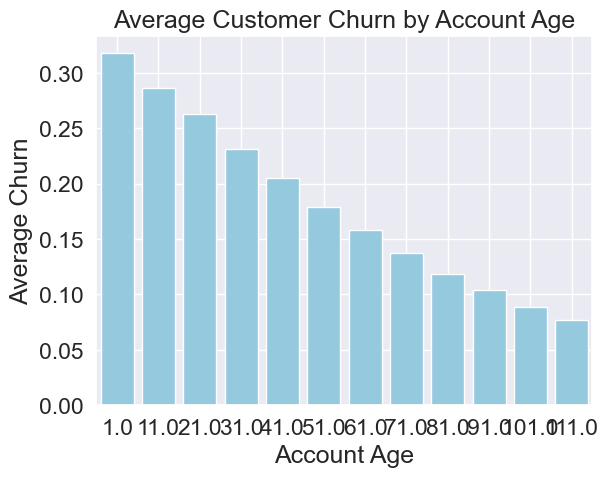

In [130]:
create_bar_plot(train_df, 'AccountAge', 'Account Age')

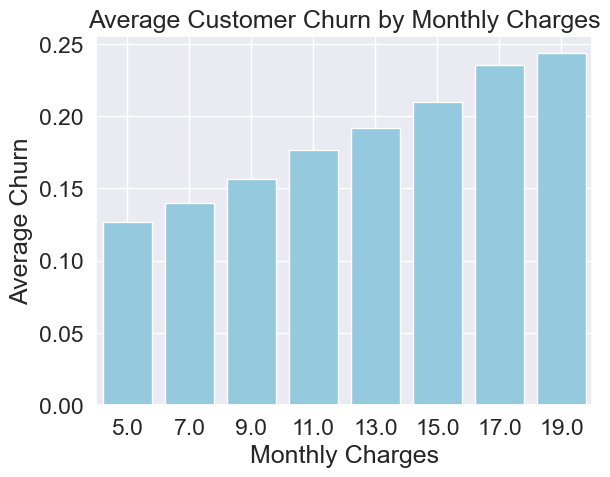

In [131]:
create_bar_plot(train_df, 'MonthlyCharges', 'Monthly Charges', 2)

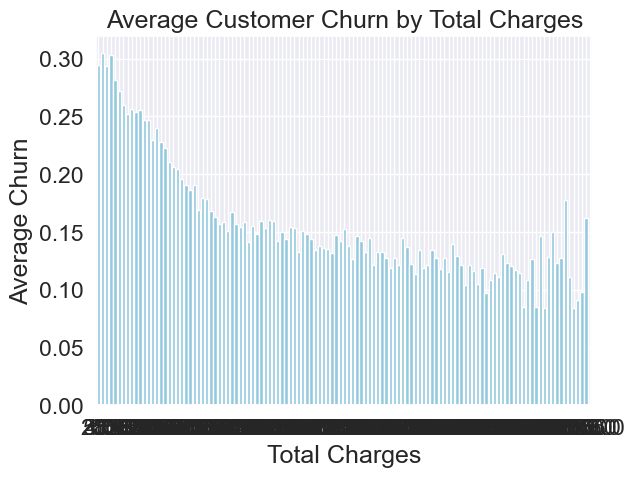

In [132]:
create_bar_plot(train_df, 'TotalCharges', 'Total Charges', 20)

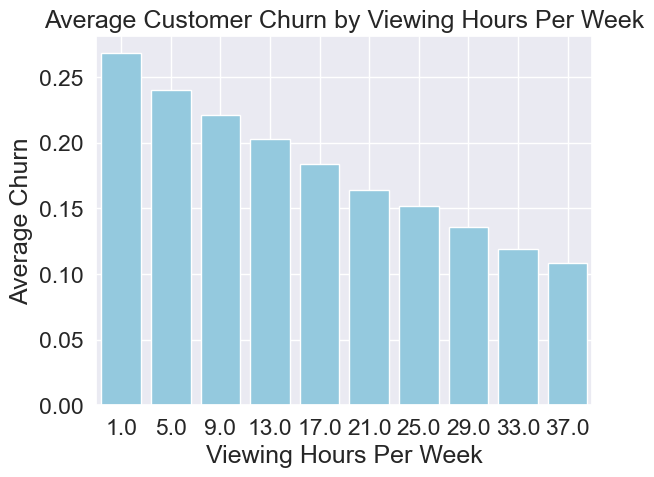

In [133]:
create_bar_plot(train_df, 'ViewingHoursPerWeek', 'Viewing Hours Per Week', 4)

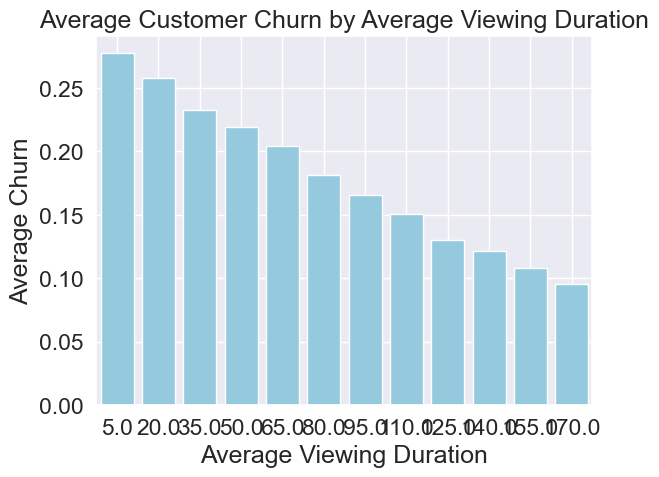

In [134]:
create_bar_plot(train_df, 'AverageViewingDuration', 'Average Viewing Duration', 15)

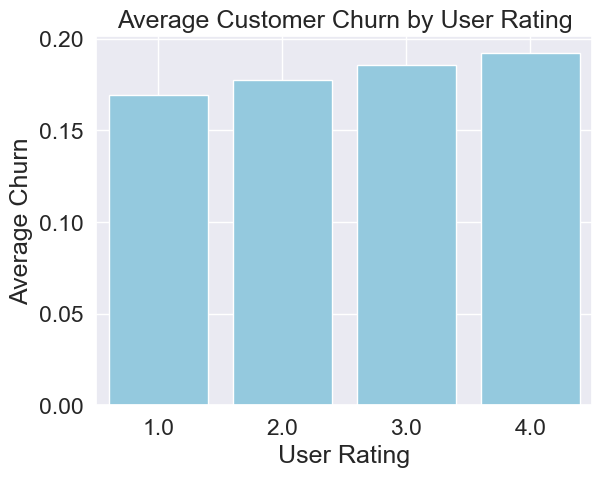

In [135]:
create_bar_plot(train_df, 'UserRating', 'User Rating', 1)

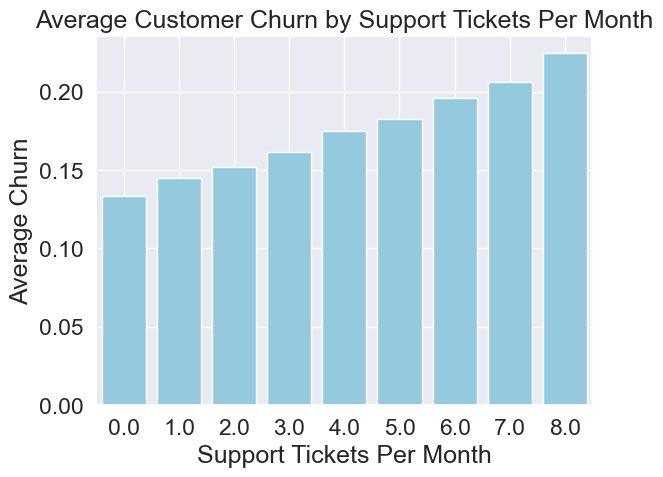

In [136]:
create_bar_plot(train_df, 'SupportTicketsPerMonth', 'Support Tickets Per Month', 1)

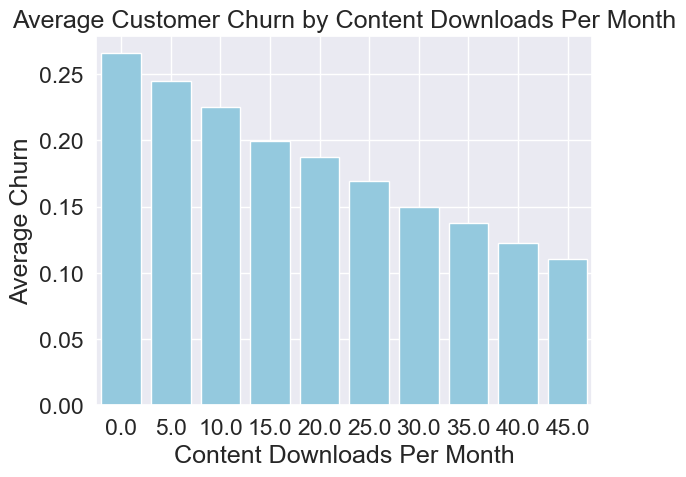

In [137]:
create_bar_plot(train_df, 'ContentDownloadsPerMonth', 'Content Downloads Per Month', 5)

In [138]:
# Get list of categorical columns excluding 'CustomerID'
categorical_columns = get_categorical_columns(train_df, exclude=['CustomerID'])
print(categorical_columns)

['SubscriptionType', 'PaymentMethod', 'PaperlessBilling', 'ContentType', 'MultiDeviceAccess', 'DeviceRegistered', 'GenrePreference', 'Gender', 'ParentalControl', 'SubtitlesEnabled']


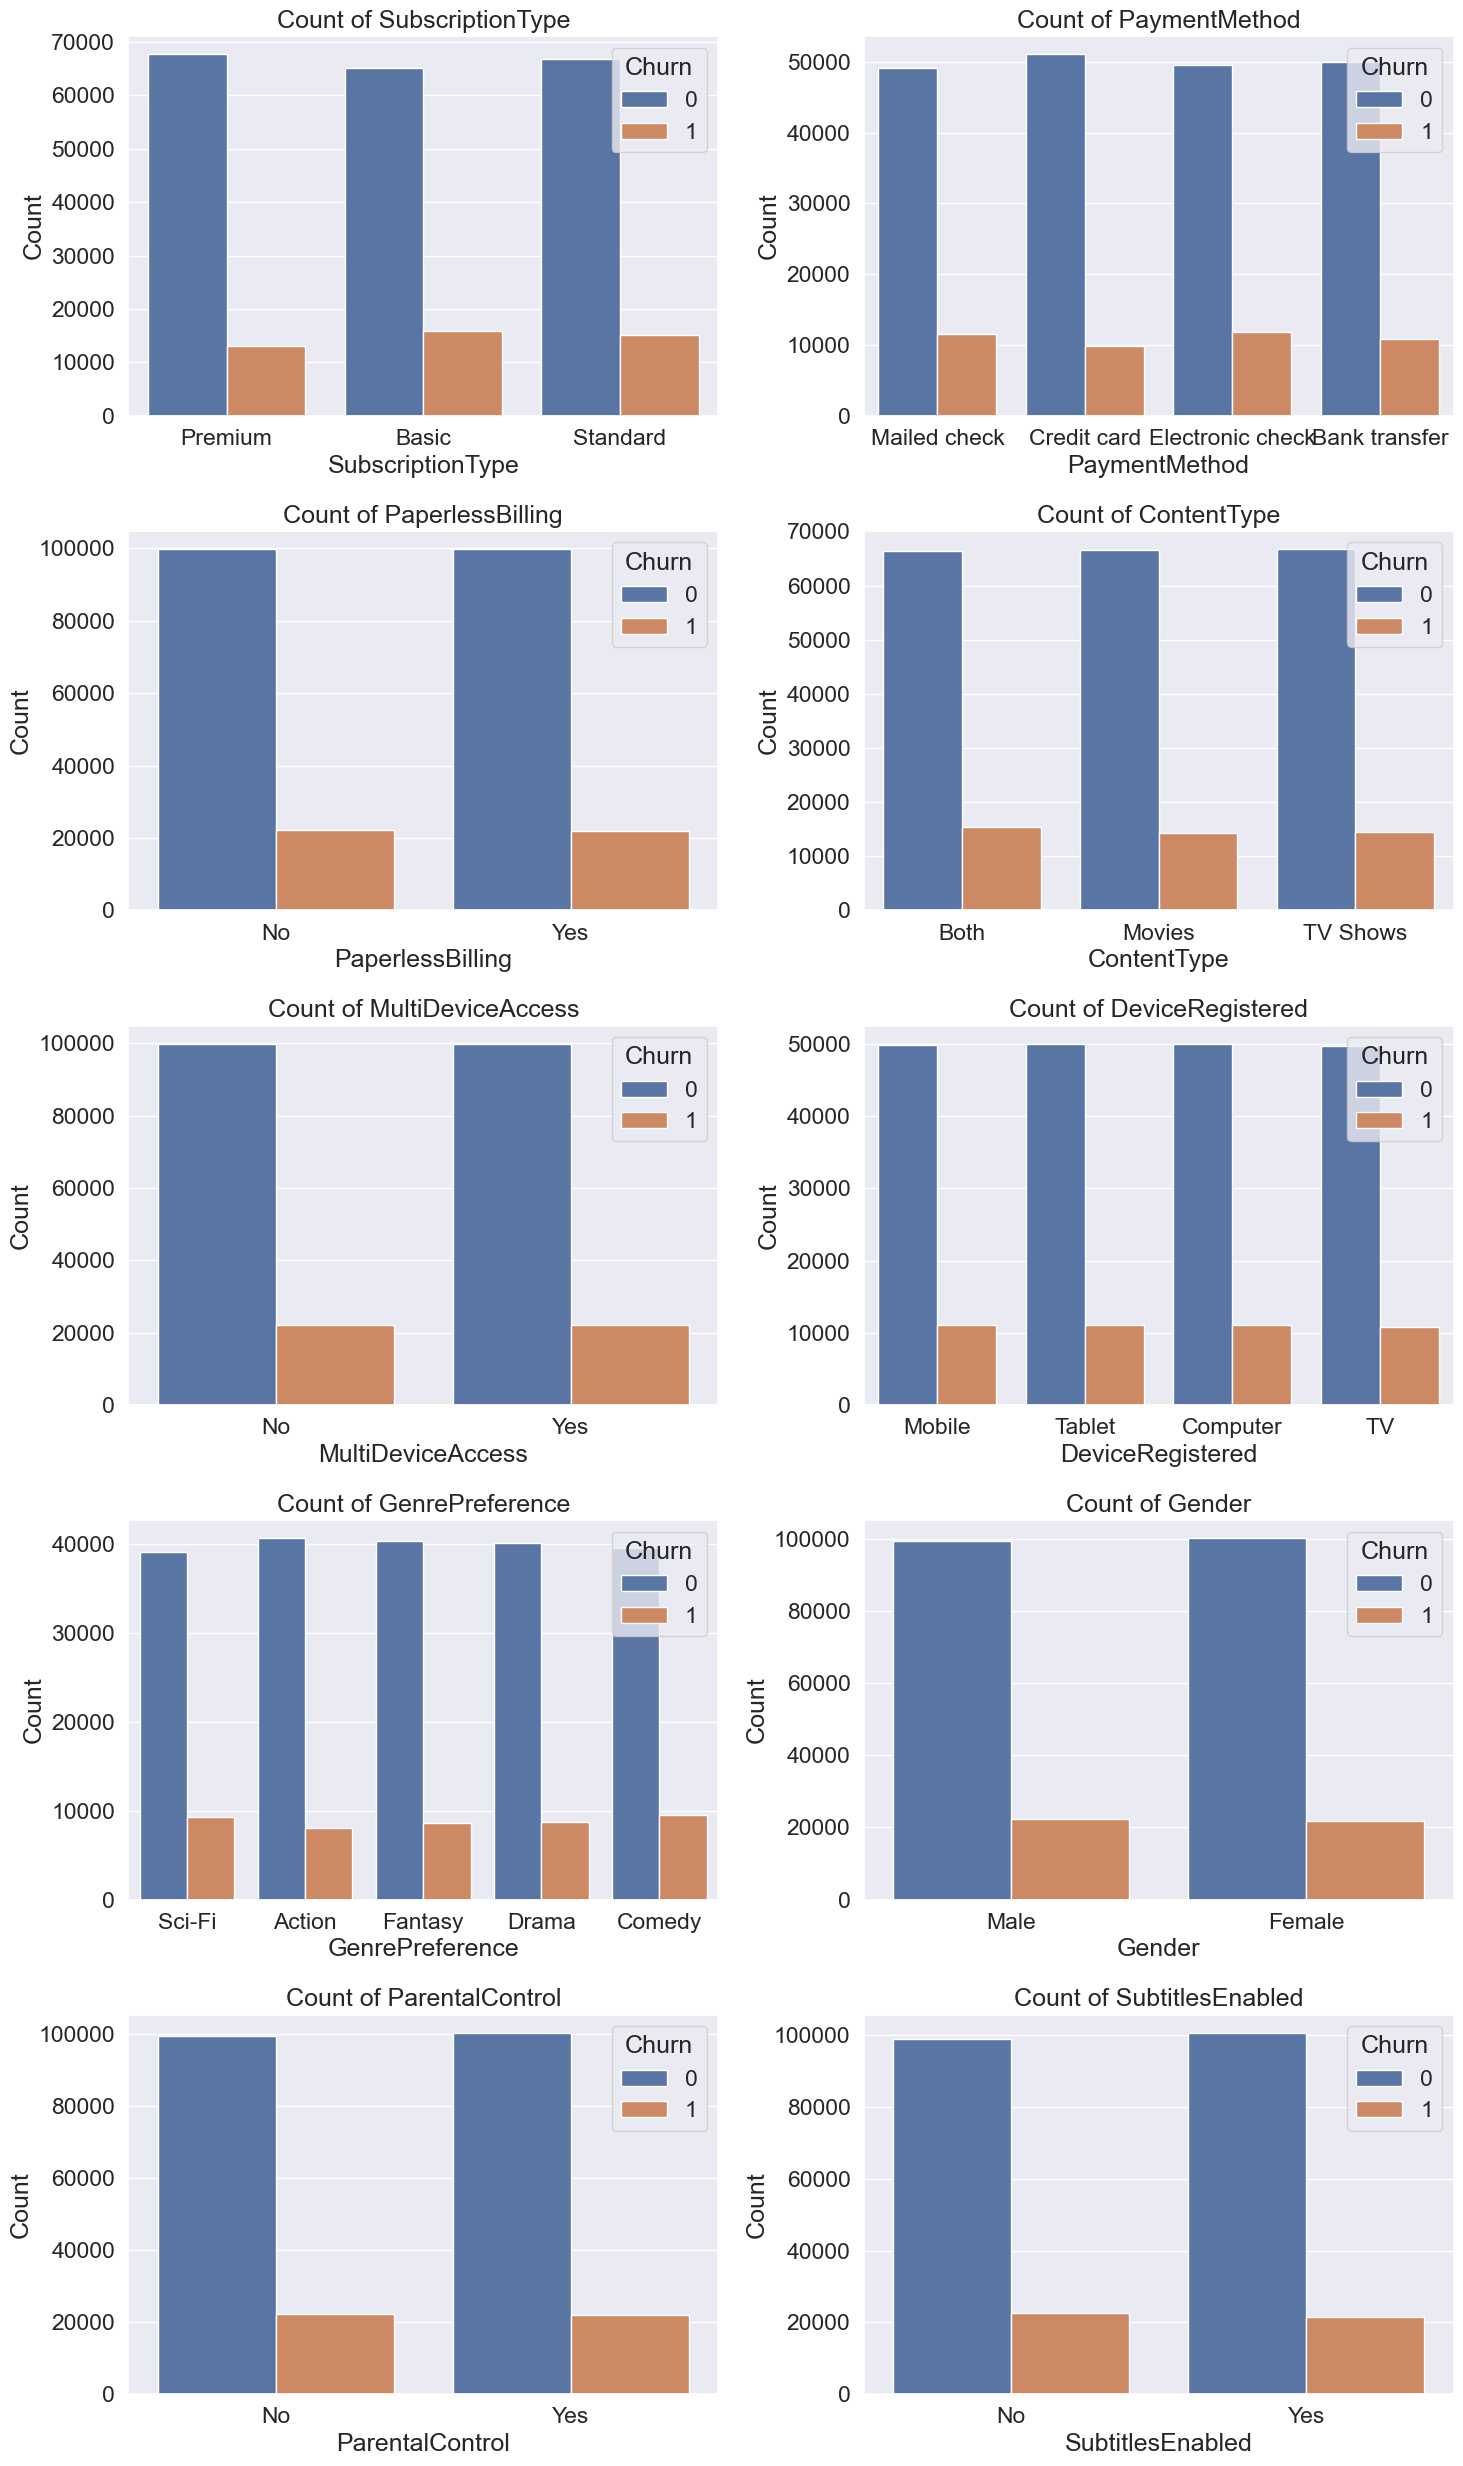

In [139]:
plot_categorical_churn_counts(train_df, categorical_columns)

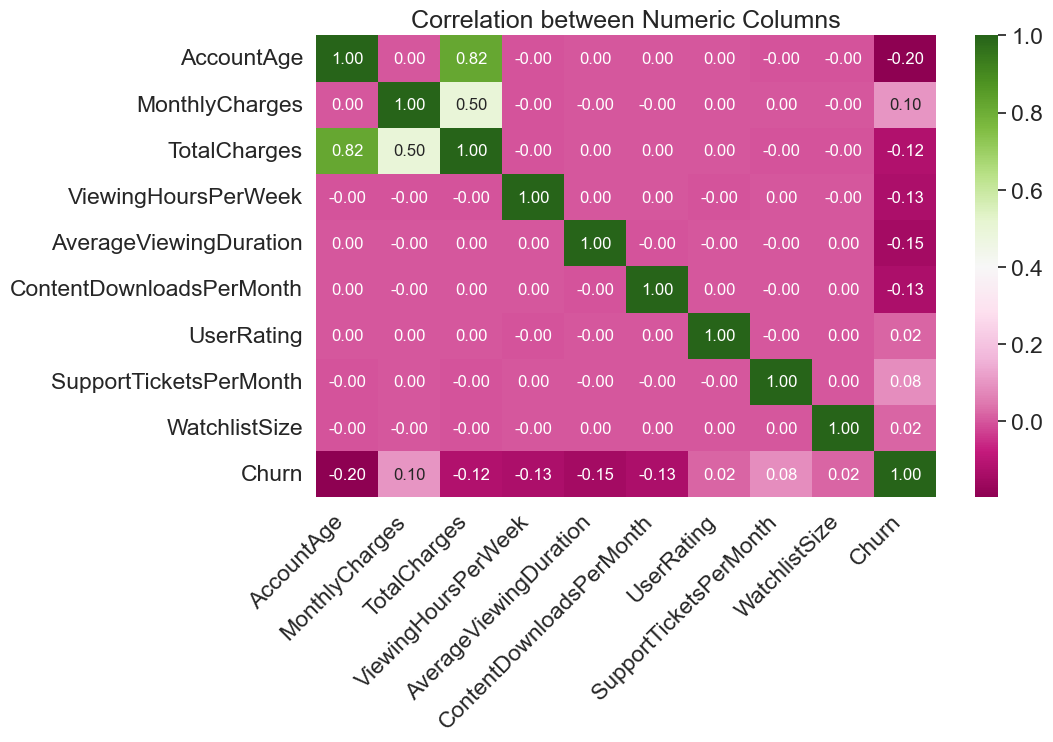

In [140]:
plot_heatmap(train_df)

## Calculate Correlation

In [141]:
correlation_scores = categorical_correlation(train_df, categorical_columns)
print(correlation_scores)

{'SubscriptionType': 0.03602862779086228, 'PaymentMethod': 0.031170586554433895, 'PaperlessBilling': 0.0, 'ContentType': 0.013040035827173132, 'MultiDeviceAccess': 0.0, 'DeviceRegistered': 0.0, 'GenrePreference': 0.026039199438169024, 'Gender': 0.007176137388359697, 'ParentalControl': 0.005135413975195599, 'SubtitlesEnabled': 0.012194370389054878}


## Calculate Churn Rate

In [142]:
for categorical_column in categorical_columns:    
    churn_rates = calculate_churn_rate(train_df, categorical_column)
    print(churn_rates)

  SubscriptionType  Churn Rate
0            Basic    0.196521
1          Premium    0.162775
2         Standard    0.184314
      PaymentMethod  Churn Rate
0     Bank transfer    0.179269
1       Credit card    0.162251
2  Electronic check    0.192471
3      Mailed check    0.190888
  PaperlessBilling  Churn Rate
0               No    0.181587
1              Yes    0.180876
  ContentType  Churn Rate
0        Both    0.188470
1      Movies    0.177764
2    TV Shows    0.177398
  MultiDeviceAccess  Churn Rate
0                No    0.181727
1               Yes    0.180736
  DeviceRegistered  Churn Rate
0         Computer    0.181350
1           Mobile    0.182372
2               TV    0.179044
3           Tablet    0.182147
  GenrePreference  Churn Rate
0          Action    0.165866
1          Comedy    0.193416
2           Drama    0.178709
3         Fantasy    0.176734
4          Sci-Fi    0.191444
   Gender  Churn Rate
0  Female    0.178356
1    Male    0.184109
  ParentalControl  Chu

In [143]:
try:
    numeric_columns = train_df.select_dtypes(include=['int', 'float']).columns
    
    for numeric_column in numeric_columns:
        churn_rates_by_bins = calculate_churn_rate_by_bins(train_df, numeric_column)
        print(churn_rates_by_bins)

except Exception as ex:
    print(f"An error occurred while processing the numeric columns: {ex}")

       AccountAge  Churn Rate
0   (0.881, 12.8]    0.311575
1    (12.8, 24.6]    0.282516
2    (24.6, 36.4]    0.246962
3    (36.4, 48.2]    0.213394
4    (48.2, 60.0]    0.181212
5    (60.0, 71.8]    0.157265
6    (71.8, 83.6]    0.133754
7    (83.6, 95.4]    0.112499
8   (95.4, 107.2]    0.095580
9  (107.2, 119.0]    0.077789
              MonthlyCharges  Churn Rate
0  (4.973999999999999, 6.49]    0.124735
1               (6.49, 7.99]    0.135495
2               (7.99, 9.49]    0.144490
3              (9.49, 10.99]    0.160000
4             (10.99, 12.49]    0.175370
5             (12.49, 13.99]    0.186208
6             (13.99, 15.49]    0.196661
7             (15.49, 16.99]    0.213406
8             (16.99, 18.49]    0.229494
9             (18.49, 19.99]    0.246406
           TotalCharges  Churn Rate
0      (2.616, 242.364]    0.273050
1    (242.364, 479.738]    0.213080
2    (479.738, 717.111]    0.164311
3    (717.111, 954.484]    0.152210
4   (954.484, 1191.857]    0.141129
5  

## Encode DataFrames

In [144]:
df_encoded_train = apply_one_hot_encoding(train_df, categorical_columns)
df_encoded_train

,AccountAge,MonthlyCharges,TotalCharges,ViewingHoursPerWeek,AverageViewingDuration,ContentDownloadsPerMonth,UserRating,SupportTicketsPerMonth,WatchlistSize,CustomerID,...,GenrePreference_Comedy,GenrePreference_Drama,GenrePreference_Fantasy,GenrePreference_Sci-Fi,Gender_Female,Gender_Male,ParentalControl_No,ParentalControl_Yes,SubtitlesEnabled_No,SubtitlesEnabled_Yes
0,20,11.055215,221.104302,36.758104,63.531377,10,2.176498,4,3,CB6SXPNVZA,...,0,0,0,1,0,1,1,0,1,0
1,57,5.175208,294.986882,32.450568,25.725595,18,3.478632,8,23,S7R2G87O09,...,0,0,0,0,0,1,1,0,0,1
2,73,12.106657,883.785952,7.395160,57.364061,23,4.238824,6,1,EASDC20BDT,...,0,0,1,0,0,1,0,1,0,1
3,32,7.263743,232.439774,27.960389,131.537507,30,4.276013,2,24,NPF69NT69N,...,0,1,0,0,0,1,0,1,0,1
4,57,16.953078,966.325422,20.083397,45.356653,20,3.616170,4,0,4LGYPK7VOL,...,1,0,0,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243782,77,9.639902,742.272460,13.502729,80.367312,47,3.697451,1,8,FBZ38J108Z,...,0,0,0,1,0,1,0,1,1,0
243783,117,13.049257,1526.763053,24.963291,59.818441,35,1.449742,4,20,W4AO1Y6NAI,...,1,0,0,0,0,1,1,0,1,0
243784,113,14.514569,1640.146267,10.628728,176.186095,44,4.012217,6,13,0H3SWWI7IU,...,0,0,0,0,0,1,0,1,0,1
243785,7,18.140555,126.983887,30.466782,153.386315,36,2.135789,7,5,63SJ44RT4A,...,0,0,1,0,1,0,1,0,0,1


In [145]:
df_encoded_test = apply_one_hot_encoding(test_df, categorical_columns)
df_encoded_test

,AccountAge,MonthlyCharges,TotalCharges,ViewingHoursPerWeek,AverageViewingDuration,ContentDownloadsPerMonth,UserRating,SupportTicketsPerMonth,WatchlistSize,CustomerID,...,GenrePreference_Comedy,GenrePreference_Drama,GenrePreference_Fantasy,GenrePreference_Sci-Fi,Gender_Female,Gender_Male,ParentalControl_No,ParentalControl_Yes,SubtitlesEnabled_No,SubtitlesEnabled_Yes
0,38,17.869374,679.036195,29.126308,122.274031,42,3.522724,2,23,O1W6BHP6RM,...,1,0,0,0,0,1,1,0,1,0
1,77,9.912854,763.289768,36.873729,57.093319,43,2.021545,2,22,LFR4X92X8H,...,0,0,0,0,1,0,0,1,1,0
2,5,15.019011,75.095057,7.601729,140.414001,14,4.806126,2,22,QM5GBIYODA,...,0,0,0,1,1,0,1,0,0,1
3,88,15.357406,1351.451692,35.586430,177.002419,14,4.943900,0,23,D9RXTK2K9F,...,1,0,0,0,1,0,0,1,0,1
4,91,12.406033,1128.949004,23.503651,70.308376,6,2.846880,6,0,ENTCCHR1LR,...,0,1,0,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104475,80,17.348236,1387.858873,19.189141,135.445204,35,1.411831,7,14,UTKREC613O,...,1,0,0,0,1,0,1,0,0,1
104476,20,8.275459,165.509180,30.986604,114.868640,17,2.783849,2,8,MDB4E477PS,...,0,1,0,0,0,1,0,1,1,0
104477,106,18.134343,1922.240365,7.236303,109.583153,31,2.991527,1,12,IPDIA02ZE1,...,1,0,0,0,0,1,1,0,0,1
104478,46,19.774010,909.604454,25.809285,115.153570,1,4.998019,0,12,ITLFTPRJGV,...,0,1,0,0,1,0,0,1,1,0


## Split Train - Test

In [146]:
# Define the columns to exclude for feature extraction
columns_to_exclude_train = ['Churn', 'CustomerID']
columns_to_exclude_test = ['CustomerID']

# Extract features and target for training data
x_train = extract_features(df_encoded_train, columns_to_exclude_train)
y_train = extract_target(df_encoded_train, 'Churn')

# Extract features for test data
x_test = extract_features(df_encoded_test, columns_to_exclude_test)

# Extract target for test/prediction data (assuming it's used for inference or submission)
y_test = extract_features(df_prediction_submission, columns_to_exclude_test)

## Evaluate Models

In [147]:
# Define the parameter grid and get the best Random Forest model
param_grid = get_rf_param_grid()  

In [148]:
best_params, best_rf_model = get_best_random_forest(x_train, y_train, param_grid)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


In [149]:
# Get the comparison models, including the best Random Forest
comparison_models = get_comparison_models(best_rf_model)

In [150]:
# Find the best model among the comparison models
best_model, best_model_name = find_best_model(comparison_models, x_train, y_train, x_test, y_test)

# Display information about the best model
print(f"The best model is: {best_model_name} with the best performance.")

Accuracy: 0.8073889739663094
Precision: 0.1826045170591062
Recall: 0.020209541030686593
F1 Score: 0.03639149588201494
Confusion Matrix:
 [[83976  1701]
 [18423   380]]
Mean CV Accuracy: 0.8228822712037974
Random Forest: Performance = 0.8073889739663094
Accuracy: 0.8014452526799387
Precision: 0.17974934036939313
Recall: 0.02898473647822156
F1 Score: 0.04991985344630181
Confusion Matrix:
 [[83190  2487]
 [18258   545]]
Mean CV Accuracy: 0.8237354748738197
Gradient Boosting Classifier: Performance = 0.8014452526799387


C:\Users\NOBITEX\PycharmProjects\Project\ChurnPredictionVideoStreamingPlatform\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.8200325421133231
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
 [[85677     0]
 [18803     0]]
Mean CV Accuracy: 0.8187680229878997
Support Vector Classifier: Performance = 0.8200325421133231


C:\Users\NOBITEX\PycharmProjects\Project\ChurnPredictionVideoStreamingPlatform\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\NOBITEX\PycharmProjects\Project\ChurnPredictionVideoStreamingPlatform\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for

Accuracy: 0.8019238131699847
Precision: 0.1791044776119403
Recall: 0.028080625432111896
F1 Score: 0.04854949197738035
Confusion Matrix:
 [[83257  2420]
 [18275   528]]
Mean CV Accuracy: 0.823751879156665
Logistic Regression: Performance = 0.8019238131699847
The best model is: Gradient Boosting Classifier with the best performance.


In [151]:
# Fit and predict with the best model
best_model.fit(x_train, y_train)
y_test_pred = best_model.predict(x_test)

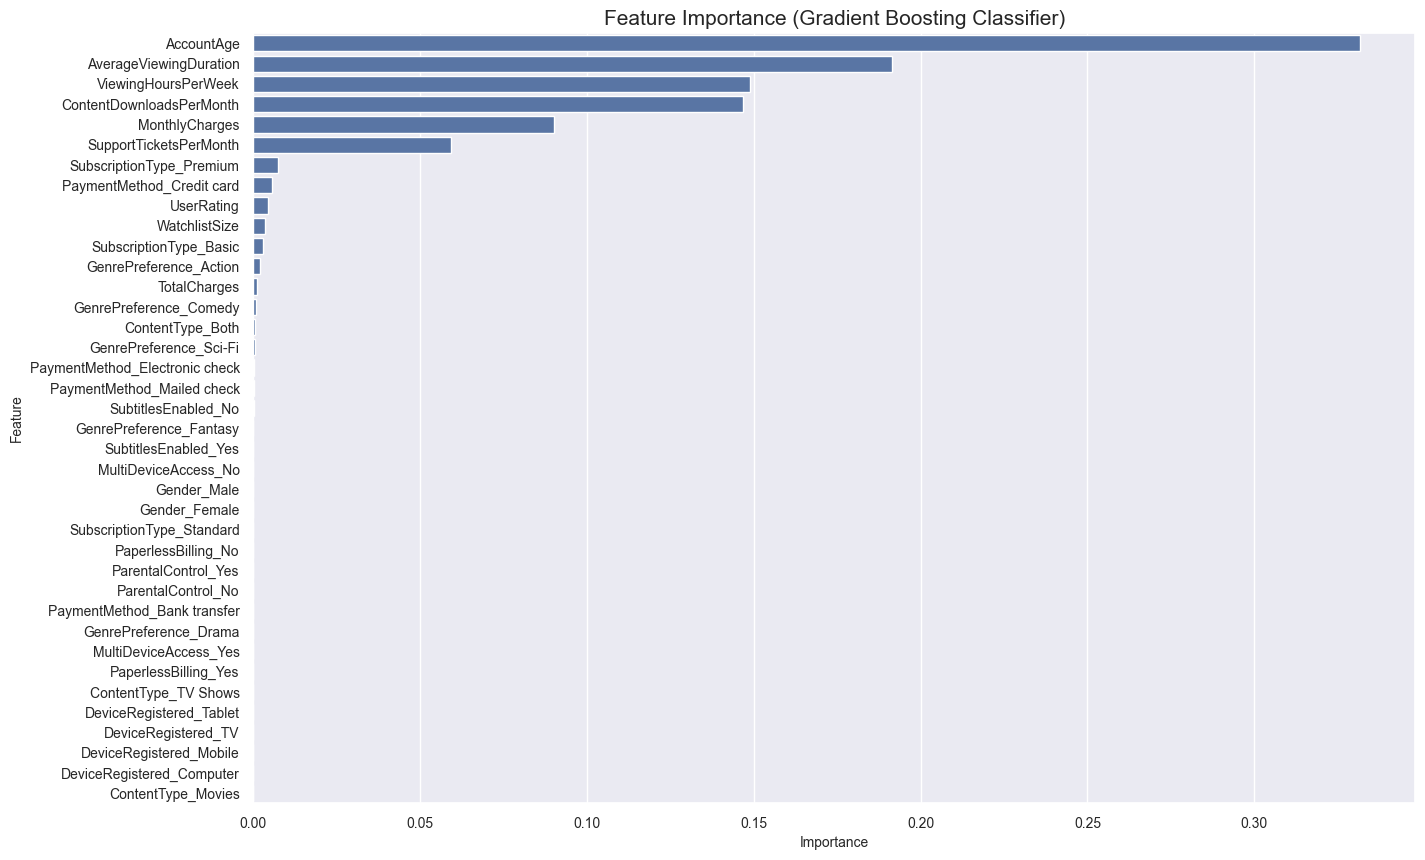

In [152]:
plot_feature_importance(best_model, x_train.columns.tolist(), best_model_name)